# HR Analytics Predictive Model

In [1]:
# Importing necessary libraries and packages
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying data frames
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset
file_path = '/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv'
data = pd.read_csv(file_path)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
data = data.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'avg_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})
cleaned_data=data.drop_duplicates(keep='first')

In [3]:
# Data manipulation from previous EDA exercise (Identifying outliers)

# 25, 75 percentile values and interquartile range
percentile25 = cleaned_data['tenure'].quantile(0.25)
percentile75 = cleaned_data['tenure'].quantile(0.75)
iqr = percentile75-percentile25

# Define upper and lower limit for non-outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print('Lower limit is:', lower_limit)
print('Upper limit is:', upper_limit)

# Subset data to the ones only containing outliers
outlier = cleaned_data[(cleaned_data['tenure'] > upper_limit) | (cleaned_data['tenure'] < lower_limit)]
print('Number of outliers in tenure:', len(outlier))

Lower limit is: 1.5
Upper limit is: 5.5
Number of outliers in tenure: 824


# Create a Prediction Model

Following the initial presentation, stakeholders were alarmed by the extent of employee dissatisfaction, particularly among the most hardworking workers who are leaving the company. In response, management has requested the development of a predictive model to identify employees who are most likely to depart.

Management plans to target these high-risk individuals as a pilot group for implementing new retention strategies, aiming to achieve a 10% increase in overall employee retention.

Given the binary nature of the 'left' variable, we will utilize a logistic regression model to accurately predict whether current employees are at risk of leaving in the near future

## 1) Logistic Regression

In [37]:
# Preparation for model building

# Copy the data frame for logistic model building
data_enc = cleaned_data.copy()

# Encoding 'salary' as a numeric category
data_enc['salary'] = (
    data_enc['salary'].astype('category')
    .cat.set_categories(['low','medium','high'])
    .cat.codes
)

# Dummy encoding the 'department' column
data_enc = pd.get_dummies(data_enc, drop_first=False)

# Check new dataset
data_enc.head()

,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


To create a model with the highest predictors, we will first delete the outliers since logistic regressions are sensitive to outliers and may affect the performance of the model.

In [6]:
# Since logistic regressions are sensitive to outliers, remove outliers in tenure.
model_data = data_enc[(data_enc['tenure'] >= lower_limit) & (data_enc['tenure'] <= upper_limit)]
model_data.shape

(11167, 19)

In [7]:
# Isolate the outcome variable 'left'
y = model_data['left']

# Selecting features to use in the model
X = model_data.drop('left', axis=1)

# Split into 80/20 training set and testing set
# Using seed of 121 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y,random_state=121)

# Constructing logistic regression model, fitting it into training data
log_model = LogisticRegression(random_state=121, max_iter=500).fit(X_train, y_train)

# Using logistic regression model to predict on test set
y_pred = log_model.predict(X_test)

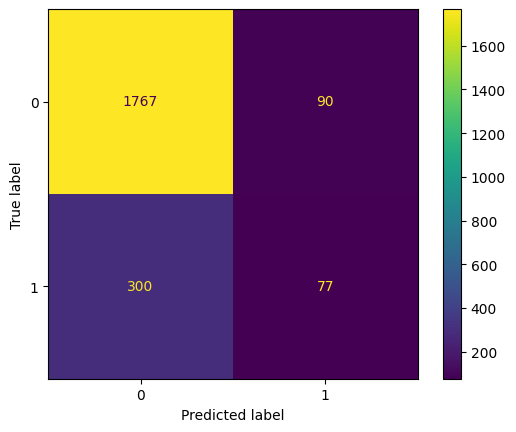

In [9]:
# Create a confusion matrix to visualize results of the model
log_cm = confusion_matrix(y_test, y_pred, labels=log_model.classes_)

# Create display of the matrix
log_display = ConfusionMatrixDisplay(confusion_matrix = log_cm,
                                    display_labels=log_model.classes_)

# Plot the matrix
log_display.plot(values_format='')
plt.show()

In [10]:
# Check class balance in the data to predict 'left'
cleaned_data['left'].value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

The test shows an approximate 83/17 split. Although the data is not perfectly balanced, it is not too imbalance to proceed with evaluating the model.

In [11]:
# Create table of results of the model
target_names = ['(P) would not leave', '(P) would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

(P) would not leave       0.85      0.95      0.90      1857
    (P) would leave       0.46      0.20      0.28       377

           accuracy                           0.83      2234
          macro avg       0.66      0.58      0.59      2234
       weighted avg       0.79      0.83      0.80      2234



The classification report for the logistic regression model shows a precision of 79%, recall of 83%, F1-score of 80% (weighted averages), and an overall accuracy of 83%. While these metrics indicate moderate performance, they fall short in effectively predicting employee departures, as approximately 20% of attrition cases may remain unrecognized. To enhance the model's predictive accuracy and better retain talent, alternative modeling approaches should be considered.

## 2) Decision Tree Model

Considering how the logistic model is underperforming, we will create a decision tree model to increase the accuracy of the predictive model.

In [38]:
# Preparing data for the model
# Isolating the outcome variable
y = data_enc['left']

# Selecting features
X = data_enc.drop('left',axis=1)

# Split testing and training data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [17]:
# Constructing the decision tree
tree = DecisionTreeClassifier(random_state=0)

# Setting up dictionary with hyperparameters to find optimal parameters
cv_params = {'max_depth':[4, 6, 8, None],
            'min_samples_leaf': [2, 5, 1],
            'min_samples_split': [2, 4, 6]
            }

# Assigning dictionary of scoring metrics of the model
tree_scores = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Setting up cross-validated grid-search for best model parameters
tree1 = GridSearchCV(tree, cv_params, scoring=tree_scores, cv=4, refit='roc_auc')

In [18]:
# Fitting the decision tree model to the training data
tree1.fit(X_train, y_train)

CPU times: user 4.96 s, sys: 1.64 ms, total: 4.96 s
Wall time: 4.99 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'roc_auc', 'precision', 'accuracy', 'f1', 'recall'})

In [19]:
# Checking best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [20]:
# Checking best AUC score
tree1.best_score_

0.9732775800960848

The model demonstrates an exceptional AUC score of 97% in predicting employee attrition. Given this strong performance, we will proceed to extract and analyze all scores from the grid search to further optimize and validate the model’s effectiveness.

In [24]:
# Create a function extract all the scores from the grid search

def extract_results(model_name:str, model_object, metric:str):
    '''
    Clarifying arguments:
        model_name (string) : name of the model in the output table
        model_object: the fit GridSearchCV model
        metric (string) : metric from precision, recall, f1, accuracy or auc
    This function is expected to return a data frame with the F1, recall, precision, accuracy and auc scores.
    It will find the best metric score across all validation folds of the model.
    '''
    # Creating a dictionary that maps the metric to GridSearchCV metric name
    metrics = {'auc': 'mean_test_roc_auc',
              'precision': 'mean_test_precision',
              'recall': 'mean_test_recall',
              'f1': 'mean_test_f1',
              'accuracy': 'mean_test_accuracy'
              }
    # Creating a data frame for all the results
    cv_results = pd.DataFrame(model_object.cv_results_)
    
    # Finding row with the highest metric score
    best_result = cv_results.iloc[cv_results[metrics[metric]].idxmax(),:]
    
    # Extracting accuracy, precision, recall and f1 score
    auc = best_result.mean_test_roc_auc
    f1 = best_result.mean_test_f1
    recall = best_result.mean_test_recall
    precision = best_result.mean_test_precision
    accuracy = best_result.mean_test_accuracy
    
    # Creating table with results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                         })
    return table

In [25]:
# Applying new function to tree1
tree1_results = extract_results('Decision Tree', tree1, 'auc')
tree1_results

,model,precision,recall,F1,accuracy,auc
0,Decision Tree,0.921868,0.916533,0.919033,0.973207,0.973278


While the decision tree model demonstrates robust performance metrics, it is inherently susceptible to overfitting, which can compromise its generalizability to new data. To mitigate this risk and enhance model reliability, we will develop a Random Forest model. By leveraging an ensemble of multiple trees, the Random Forest approach reduces variance and improves prediction accuracy, ensuring more stable and accurate forecasts of employee attrition.

## 3) Random Forest

In [26]:
# Creating Model
rf = RandomForestClassifier(random_state=0)

# Assigning dictionary with hyperparameters
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

# Creating dictionary with scoring metrics
forest_scores = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Initiating GridSearch
rf_model = GridSearchCV(rf, cv_params, scoring=forest_scores, cv=4, refit='roc_auc')

In [29]:
# Fitting model to training data
rf_model.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'roc_auc', 'precision', 'accuracy', 'f1', 'recall'})

In [31]:
# Identifying best AUC score on training set
print(rf_model.best_score_)

# Checking best parameters
rf_model.best_params_

0.9808004396490351


{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

In [32]:
#Getting all CV scores
rf_model_results = extract_results('Random Forest', rf_model, 'auc')
print(tree1_results)
print(rf_model_results)

           model  precision    recall        F1  accuracy       auc
0  Decision Tree   0.921868  0.916533  0.919033  0.973207  0.973278
           model  precision    recall        F1  accuracy     auc
0  Random Forest   0.953471  0.911506  0.931912  0.977898  0.9808


The evaluation scores of the random forest are superior to the decision tree model, with the exception of the recall being lower by 0.005 (a negligible amount). The results show that the random forest model mostly outperforms the decision tree model.

Now, we will use the random forest model on the test set.

In [33]:
# Create a function that gets all scores from the model's predictions
def pred_results(model_name:str, model, X_test_data, y_test_data):
    '''
    Clarifying arguments:
        model_name (string): name of the model in the output table
        model: the GridSearch CV model name
        X_test_data: X_test data
        Y_test_data: Y_test data
    This is going to create a metrics table, similar to the one created for the train data.
    '''
    pred = model.best_estimator_.predict(X_test_data)
    
    auc = roc_auc_score(y_test_data, pred)
    accuracy = accuracy_score(y_test_data, pred)
    precision = precision_score(y_test_data, pred)
    recall = recall_score(y_test_data, pred)
    f1 = f1_score(y_test_data, pred)
    
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
    return table

In [34]:
rf_model_test_scores = pred_results('Random Forest Test', rf_model, X_test, y_test)
rf_model_test_scores

,model,precision,recall,F1,accuracy,AUC
0,Random Forest Test,0.949868,0.904523,0.926641,0.97624,0.947514


The test scores closely align with the validation scores, increasing the reliability of the model. This consistency suggests that the model generalizes well, providing confidence that its performance on the test set will be similar on new, unseen data.

While the AUC decreased by 3%, indicating a slight reduction in the model's ability to distinguish between classes, the precision remained nearly identical. This minimal decline in AUC suggests a minor trade-off in overall discriminative power, yet the sustained precision ensures that the proportion of correctly identified positive cases remains high.

Finally, we will create a confusion matrix to visualize the predictions on the test set.

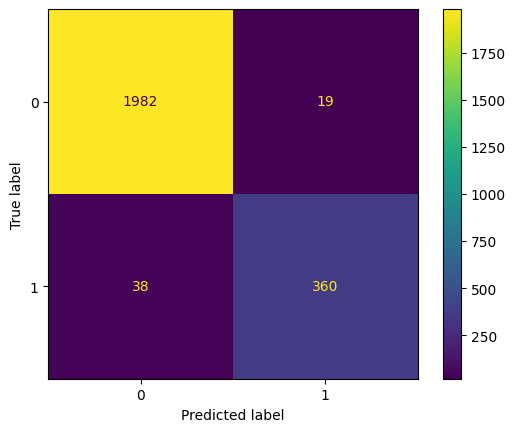

In [36]:
# Generating confusion matrix
pred = rf_model.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, pred, labels=rf_model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
display.plot(values_format='');

While the model exhibits a higher rate of false positives compared to false negatives—meaning that some employees are incorrectly flagged as at risk of leaving—the overall performance remains strong. This tendency indicates that the model may identify more employees for retention efforts than necessary. However, the high precision and recall metrics ensure that the majority of actual attrition cases are accurately predicted. Consequently, the model effectively balances the trade-off between identifying potential leavers and minimizing missed opportunities for intervention, making it a valuable tool for proactive employee retention strategies.abs

## Conclusion

This project successfully developed a robust predictive model to forecast employee attrition at AlphaLogistics. Through comprehensive exploratory data analysis, we identified critical factors influencing turnover, including workload, satisfaction levels, and tenure. The final Random Forest model achieved a precision of 95%, recall of 90%, an F1-score of 93%, and an overall accuracy of 98%, demonstrating a solid capability to predict employee departures. This model equips HR executives with valuable insights to implement targeted retention strategies, effectively reducing turnover and fostering a more engaged and stable workforce. Moving forward, continuous model optimization and integration with real-time HR data will ensure sustained accuracy and adaptability, enabling AlphaLogistics to proactively address employee attrition and maintain a competitive edge in talent management